# Preparing Alpha Factors and Features to predict Stock Returns

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2013-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading Quandl Wiki Stock Prices & Meta Data

In [6]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [7]:
DATA_STORE = '../data/assets.h5'

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])

In [9]:
prices

open      close        low       high    volume
ticker date                                                            
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500
...                      ...        ...        ...        ...       ...
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040

[3619403 rows x 5 columns]

## Remove stocks with few observations

In [10]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()
print(nobs.index)
# keep those that exceed the limit
keep = nobs[nobs > min_obs].index
print(keep)

prices = prices.loc[idx[keep, :], :]

Index(['A', 'AA', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT',
       ...
       'ZIOP', 'ZIXI', 'ZLC', 'ZLTQ', 'ZMH', 'ZNGA', 'ZOES', 'ZQK', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=3196)
Index(['A', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW',
       ...
       'ZION', 'ZIOP', 'ZIXI', 'ZLTQ', 'ZMH', 'ZNGA', 'ZOES', 'ZQK', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=3057)


In [11]:
prices

open      close        low       high    volume
ticker date                                                            
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500
...                      ...        ...        ...        ...       ...
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040

[3566454 rows x 5 columns]

In [12]:
stocks

,marketcap,ipoyear,sector
ticker,,,
PIH,4.309000e+07,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,7.033000e+07,NaN,Finance
FLWS,8.333900e+08,1999.0,Consumer Services
FCCY,1.781400e+08,NaN,Finance
...,...,...,...
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation


### Align price and meta data

In [13]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [14]:
stocks

,marketcap,ipoyear,sector
ticker,,,
PIH,4.309000e+07,2014.0,finance
PIHPP,NaN,NaN,finance
TURN,7.033000e+07,NaN,finance
FLWS,8.333900e+08,1999.0,consumer_services
FCCY,1.781400e+08,NaN,finance
...,...,...,...
ZOES,1.974000e+08,2014.0,consumer_services
ZTS,4.165000e+10,2013.0,health_care
ZTO,1.434000e+10,2016.0,transportation


In [15]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [16]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2904233 non-null  float64
 1   close   2904233 non-null  float64
 2   low     2904233 non-null  float64
 3   high    2904233 non-null  float64
 4   volume  2904233 non-null  float64
dtypes: float64(5)
memory usage: 122.6+ MB


In [17]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2348 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2345 non-null   float64
 1   ipoyear    1026 non-null   float64
 2   sector     2348 non-null   object 
dtypes: float64(2), object(1)
memory usage: 73.4+ KB


In [18]:
stocks.sector.value_counts()

sector
consumer_services        440
finance                  393
technology               297
health_care              297
capital_goods            227
basic_industries         138
consumer_non-durables    126
energy                   123
public_utilities         105
consumer_durables         78
miscellaneous             69
transportation            55
Name: count, dtype: int64

Optional: persist intermediate results:

In [19]:
# with pd.HDFStore('tmp.h5') as store:
#     store.put('prices', prices)
#     store.put('stocks', stocks)

In [20]:
# with pd.HDFStore('tmp.h5') as store:
#     prices = store['prices']
#     stocks = store['stocks']

## Compute Rolling Average Dollar Volume

In [21]:
match = prices.index.get_level_values('ticker').unique() == stocks.index
match[match == False]

array([], dtype=bool)

In [22]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [23]:
prices.dollar_vol.groupby("ticker").last()

ticker
A        71071.17583
AAL     139470.16116
AAMC       505.26720
AAN      19838.96385
AAOI     56164.36408
            ...     
ZIXI       813.01998
ZNGA     20717.22800
ZOES      6508.19312
ZTS     121603.15980
ZUMZ      4623.98300
Name: dollar_vol, Length: 2348, dtype: float64

In [24]:
prices.groupby('ticker')["dollar_vol"].rolling(window=21).mean()

ticker  ticker  date      
A       A       2013-01-02             NaN
                2013-01-03             NaN
                2013-01-04             NaN
                2013-01-07             NaN
                2013-01-08             NaN
                                  ...     
ZUMZ    ZUMZ    2017-12-22    11930.001226
                2017-12-26    11963.373076
                2017-12-27    11786.938512
                2017-12-28    11290.208650
                2017-12-29    10790.612631
Name: dollar_vol, Length: 2904233, dtype: float64

In [25]:
prices['dollar_vol_1m'] = (prices.groupby('ticker')["dollar_vol"]
                           .rolling(window=21) # do a rolling window per ticker
                           .mean()).reset_index(level = 0 , drop=True) # get rolling window mean for 1 month

In [26]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  
ticker date                                      
A      2013-01-02  181430.981611            NaN  
       2013-01-03  119142.939438            NaN  
       2013-01-04  135882.822089            NaN  
       2013-01-07   75273.116328            NaN  
       2013-01-08   81066.830411            NaN  
...                          ...            ...  
ZUMZ   2017-12-22    4495.598250   11930.001226  
       2017-12-26    4674.829350   11963.373076  
       2017-12-27    4807.923750   11786.938512  
       2017-12-28    3435.884000   11290.208650  
       2017-12-29    4623.983000   10790.612631  

[2904233 rows x 7 columns]

In [27]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           2904233 non-null  float64
 1   close          2904233 non-null  float64
 2   low            2904233 non-null  float64
 3   high           2904233 non-null  float64
 4   volume         2904233 non-null  float64
 5   dollar_vol     2904233 non-null  float64
 6   dollar_vol_1m  2857273 non-null  float64
dtypes: float64(7)
memory usage: 166.9+ MB


In [28]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [29]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2904233 non-null  float64
 1   close            2904233 non-null  float64
 2   low              2904233 non-null  float64
 3   high             2904233 non-null  float64
 4   volume           2904233 non-null  float64
 5   dollar_vol       2904233 non-null  float64
 6   dollar_vol_1m    2857273 non-null  float64
 7   dollar_vol_rank  2857273 non-null  float64
dtypes: float64(8)
memory usage: 189.1+ MB


## Add some Basic Factors

### Compute the Relative Strength Index

In [30]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI).reset_index(level=0, drop=True)

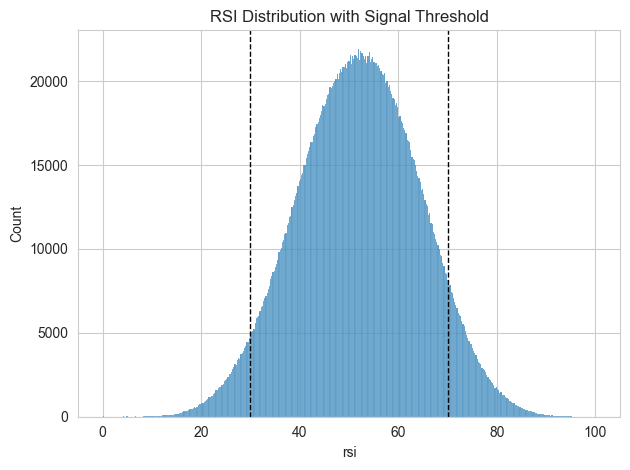

In [31]:
ax = sns.histplot(prices.rsi.dropna()) # plot rsi distribution
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [32]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [33]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  
ticker date                                                                  
A      2013-01-02  181430.981611            NaN              NaN        NaN  
       2013-01-03  119142.939438            NaN              NaN        NaN  
       2013-01-04  135882.822089            NaN              NaN        NaN  
       2013-01-07   75273.116328            NaN              NaN        NaN  
       2013-01-08   81066.830411            NaN              NaN        NaN  
...                          ...            ...              ...        ...  
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094  
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097  
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727  
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082  
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469  

[2904233 rows x 9 columns]

In [34]:
bbands = prices.groupby("ticker").close.apply(compute_bb).reset_index(level=0, drop=True)
bbands

bb_high     bb_low
ticker date                            
A      2013-01-02        NaN        NaN
       2013-01-03        NaN        NaN
       2013-01-04        NaN        NaN
       2013-01-07        NaN        NaN
       2013-01-08        NaN        NaN
...                      ...        ...
ZUMZ   2017-12-22  22.086859  19.503141
       2017-12-26  22.073133  19.781867
       2017-12-27  22.063697  19.896303
       2017-12-28  22.083536  19.911464
       2017-12-29  21.972038  19.925462

[2904233 rows x 2 columns]

In [35]:
prices = prices.join(bbands)
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                     bb_high     bb_low  
ticker date                              
A      2013-01-02        NaN        NaN  
       2013-01-03        NaN        NaN  
       2013-01-04        NaN        NaN  
       2013-01-07        NaN        NaN  
       2013-01-08        NaN        NaN  
...                      ...        ...  
ZUMZ   2017-12-22  22.086859  19.503141  
       2017-12-26  22.073133  19.781867  
       2017-12-27  22.063697  19.896303  
       2017-12-28  22.083536  19.911464  
       2017-12-29  21.972038  19.925462  

[2904233 rows x 11 columns]

In [ ]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p) # getting percentage change and applying log(1 + p) to it to smooth it out 
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p) # standardize it so it's the same across all assets

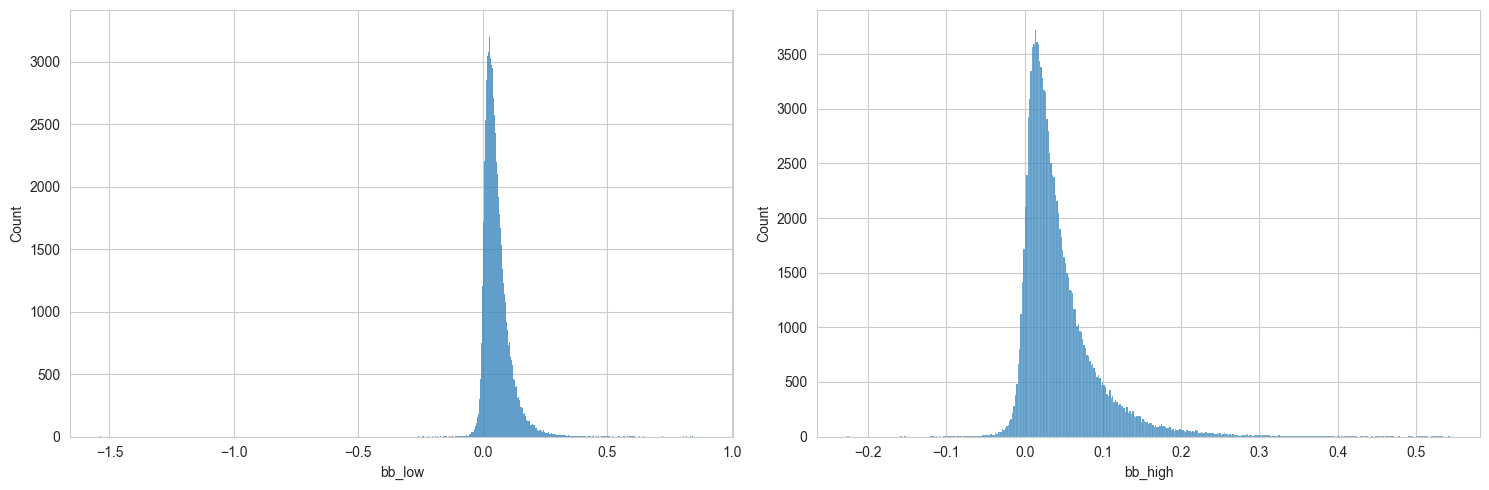

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.histplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [38]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [39]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

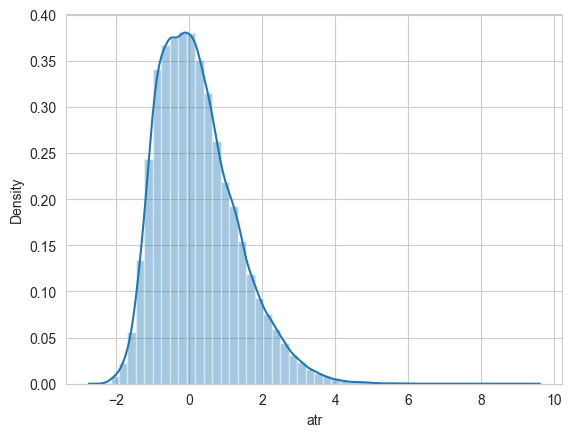

In [40]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [41]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd) # to put ticker's macd on the same scale 

In [42]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [43]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,826,749.0
mean             0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

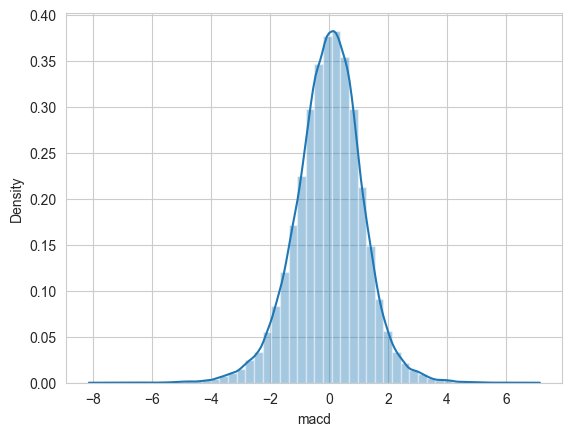

In [44]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [49]:
lags = [1, 5, 10, 21, 42, 63]

In [45]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high    bb_low       atr      macd  
ticker date                                                
A      2013-01-02       NaN       NaN       NaN       NaN  
       2013-01-03       NaN       NaN       NaN       NaN  
       2013-01-04       NaN       NaN       NaN       NaN  
       2013-01-07       NaN       NaN       NaN       NaN  
       2013-01-08       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
ZUMZ   2017-12-22  0.028426  0.086877 -0.419131  0.851425  
       2017-12-26  0.010058  0.090436 -0.450751  0.889373  
       2017-12-27  0.040577  0.057586 -0.282948  0.832724  
       2017-12-28  0.039229  0.059005 -0.449763  0.784419  
       2017-12-29  0.050887  0.042288 -0.515043  0.696842  

[2904233 rows x 13 columns]

In [46]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,9.37%
min,-87.62%
0.01%,-33.40%
0.1%,-14.78%
1%,-6.52%
50%,0.04%
99%,6.98%
99.9%,17.03%
99.99%,39.25%
max,"10,280.40%"


In [47]:
q = 0.0001

### Winsorize outliers

In [ ]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                ) # calculate lagged daily returns for a given lag period 

### Shift lagged returns

In [51]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

## Compute Forward Returns

In [52]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [53]:
prices = prices.join(stocks[['sector']])

## Create time and sector dummy variables

In [54]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [56]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 46 columns):
 #   Column           Dtype  
---  ------           -----  
 0   open             float64
 1   close            float64
 2   low              float64
 3   high             float64
 4   volume           float64
 5   dollar_vol       float64
 6   dollar_vol_1m    float64
 7   dollar_vol_rank  float64
 8   rsi              float64
 9   bb_high          float64
 10  bb_low           float64
 11  atr              float64
 12  macd             float64
 13  return_1d        float64
 14  return_5d        float64
 15  return_10d       float64
 16  return_21d       float64
 17  return_42d       float64
 18  return_63d       float64
 19  return_1d_lag1   float64
 20  return_5d_lag1   float64
 21  return_10d_lag1  float64
 22  return_21d_lag1  float64
 23  return_1d_lag2   float64
 24  return_5d_lag2   float64
 25 

In [58]:
prices

open      close        low       high    volume  \
ticker date                                                               
A      2013-01-02  29.054711  28.854904  28.351942  29.054711  6287.700   
       2013-01-03  28.896244  28.958253  28.648276  29.034042  4114.300   
       2013-01-04  29.034042  29.530115  28.841124  29.592124  4601.500   
       2013-01-07  29.350977  29.316528  29.199399  29.488775  2567.600   
       2013-01-08  29.261408  29.082271  29.006482  29.474995  2787.500   
...                      ...        ...        ...        ...       ...   
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585   
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951   
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325   
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070   
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
A      2013-01-02  181430.981611            NaN              NaN        NaN   
       2013-01-03  119142.939438            NaN              NaN        NaN   
       2013-01-04  135882.822089            NaN              NaN        NaN   
       2013-01-07   75273.116328            NaN              NaN        NaN   
       2013-01-08   81066.830411            NaN              NaN        NaN   
...                          ...            ...              ...        ...   
ZUMZ   2017-12-22    4495.598250   11930.001226           1288.0  61.077094   
       2017-12-26    4674.829350   11963.373076           1291.0  63.799097   
       2017-12-27    4807.923750   11786.938512           1293.0  56.369727   
       2017-12-28    3435.884000   11290.208650           1300.0  56.757082   
       2017-12-29    4623.983000   10790.612631           1312.0  52.959469   

                    bb_high  ...  return_5d_lag5  return_10d_lag5  \
ticker date                  ...                                    
A      2013-01-02       NaN  ...             NaN              NaN   
       2013-01-03       NaN  ...             NaN              NaN   
       2013-01-04       NaN  ...             NaN              NaN   
       2013-01-07       NaN  ...             NaN              NaN   
       2013-01-08       NaN  ...             NaN              NaN   
...                     ...  ...             ...              ...   
ZUMZ   2017-12-22  0.028426  ...        0.001647         0.003633   
       2017-12-26  0.010058  ...        0.000000        -0.000856   
       2017-12-27  0.040577  ...        0.010119        -0.005377   
       2017-12-28  0.039229  ...        0.017985        -0.008980   
       2017-12-29  0.050887  ...        0.007702        -0.012096   

                   return_21d_lag5  target_1d  target_5d  target_10d  \
ticker date                                                            
A      2013-01-02              NaN   0.003582   0.006924    0.002759   
       2013-01-03              NaN   0.019748   0.007685    0.004294   
       2013-01-04              NaN  -0.007233   0.002646    0.002970   
       2013-01-07              NaN  -0.007991   0.004611    0.004807   
       2013-01-08              NaN   0.027008   0.004833    0.004844   
...                            ...        ...        ...         ...   
ZUMZ   2017-12-22         0.001177   0.018648        NaN         NaN   
       2017-12-26         0.001556  -0.032037        NaN         NaN   
       2017-12-27         0.003478   0.002364        NaN         NaN   
       2017-12-28         0.001167  -0.017689        NaN         NaN   
       2017-12-29         0.002110        NaN        NaN         NaN   

                   target_21d             sector  year  month  
ticker date                                                    
A      2013-01-02    0.003734      capital_goods  2013   

In [59]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

In [60]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [62]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('A', Timestamp('2013-01-02 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   open                   float64
 1   close                  float64
 2   low                    float64
 3   high                   float64
 4   volume                 float64
 5   dollar_vol             float64
 6   dollar_vol_1m          float64
 7   dollar_vol_rank        float64
 8   rsi                    float64
 9   bb_high                float64
 10  bb_low                 float64
 11  atr                    float64
 12  macd                   float64
 13  return_1d              float64
 14  return_5d              float64
 15  return_10d             float64
 16  return_21d             float64
 17  return_42d             float64
 18  return_63d             float64
 19  return_1d_lag1         float64
 20  return_5d_lag1   

## Store Model Data

In [63]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

### Plot Factors

In [69]:
target = 'target_21d'
top100 = prices[prices.dollar_vol_rank<100].copy()

In [70]:
top100

open      close        low       high       volume  \
ticker date                                                                  
AAL    2013-01-31  37.104325  37.104325  36.948425  37.805878  4575.799880   
       2013-02-01  37.494077  36.688591  36.428756  37.857844  5308.600156   
       2013-02-04  36.584657  36.350806  36.246872  37.468093  4440.999918   
       2013-02-05  36.714574  36.610640  36.013022  37.052358  4175.899866   
       2013-02-06  36.532690  37.831861  36.532690  37.883828  5239.799933   
...                      ...        ...        ...        ...          ...   
ZTS    2014-11-28  43.812843  43.989073  43.812843  44.145723  1332.156000   
       2014-12-01  44.253419  43.440801  43.333105  44.292581  3153.115000   
       2014-12-02  43.440801  43.803052  43.352686  44.008655  2500.597000   
       2014-12-03  43.803052  43.940121  43.460382  44.067398  2008.310000   
       2014-12-04  43.852005  43.078550  42.931691  43.959702  4294.633000   

                      dollar_vol  dollar_vol_1m  dollar_vol_rank        rsi  \
ticker date                                                                   
AAL    2013-01-31  169781.967095  269408.517660             78.0  50.495665   
       2013-02-01  194765.057401  267159.426540             78.0  48.225193   
       2013-02-04  161433.926707  265722.598556             77.0  46.399680   
       2013-02-05  152882.367777  251044.065645             84.0  48.029390   
       2013-02-06  198231.383019  249961.346676             87.0  54.960723   
...                          ...            ...              ...        ...   
ZTS    2014-11-28   58600.308107  294715.115434             90.0  71.884144   
       2014-12-01  136973.841193  297525.671580             92.0  67.137279   
       2014-12-02  109533.781479  298272.515355             88.0  68.612084   
       2014-12-03   88245.383471  295315.035852             87.0  69.175766   
       2014-12-04  185006.560464  286390.276661             95.0  61.677853   

                    bb_high  ...  consumer_durables  consumer_non-durables  \
ticker date                  ...                                             
AAL    2013-01-31  0.071074  ...              False                  False   
       2013-02-01  0.076023  ...              False                  False   
       2013-02-04  0.085744  ...              False                  False   
       2013-02-05  0.079754  ...              False                  False   
       2013-02-06  0.046886  ...              False                  False   
...                     ...  ...                ...                    ...   
ZTS    2014-11-28  0.043559  ...              False                  False   
       2014-12-01  0.051976  ...              False                  False   
       2014-12-02  0.041573  ...              False                  False   
       2014-12-03  0.038192  ...              False                  False   
       2014-12-04  0.051743  ...              False                  False   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
AAL    2013-01-31              False   False    False        False   
       2013-02-01              False   False    False        False   
       2013-02-04              False   False    False        False   
       2013-02-05              False   False    False        False   
       2013-02-06              False   False    False        False   
...                              ...     ...      ...          ...   
ZTS    2014-11-28              False   False    False         True   
       2014-12-01              False   False    False         True   
       2014-12-02              False   False    False         True   
       2014-12-03              False   False    False         True   
       2014-12-04              False   False    False         True   

                   miscellaneous  public_utilities  tec

### RSI

In [71]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [73]:
top100.groupby('rsi_signal')['target_21d'].describe() # grouping by where the RSi is, find out future return in the next 5 days 
# we can see from below that in overbought regions, we can remain positive for a long time 

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4188.0,0.000307,0.004861,-0.031093,-0.001977,0.000682,0.002880,0.028536
"(30, 70]",105907.0,0.000431,0.003683,-0.057759,-0.001352,0.000588,0.002405,0.030792
"(70, 100]",10393.0,0.000231,0.003122,-0.042584,-0.001288,0.000314,0.001886,0.018457


### Bollinger Bands

-2.47% (0.00%)


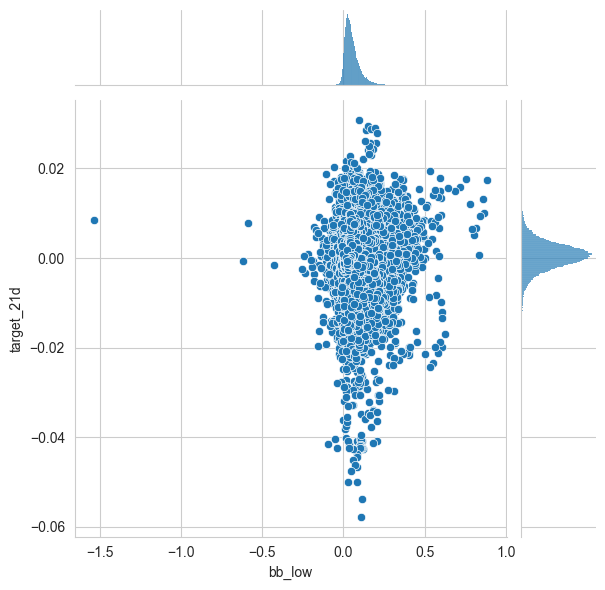

In [76]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target]) # spearman rank just computes correlation formula on rank of two diff variables 
print(f'{r:,.2%} ({p:.2%})')

# negative correlation means that when bb low is negative, price is below lower BBand, so price goes up , but not very strong correlation 

3.75% (0.00%)


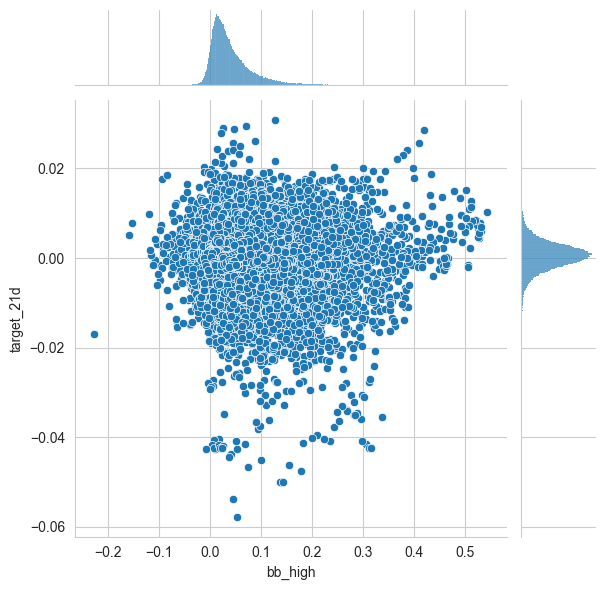

In [77]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### ATR

-3.77% (0.00%)


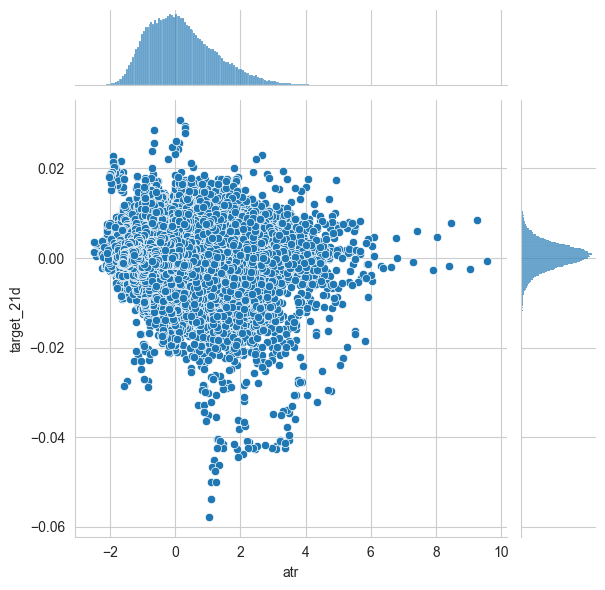

In [78]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### MACD

-7.47% (0.00%)


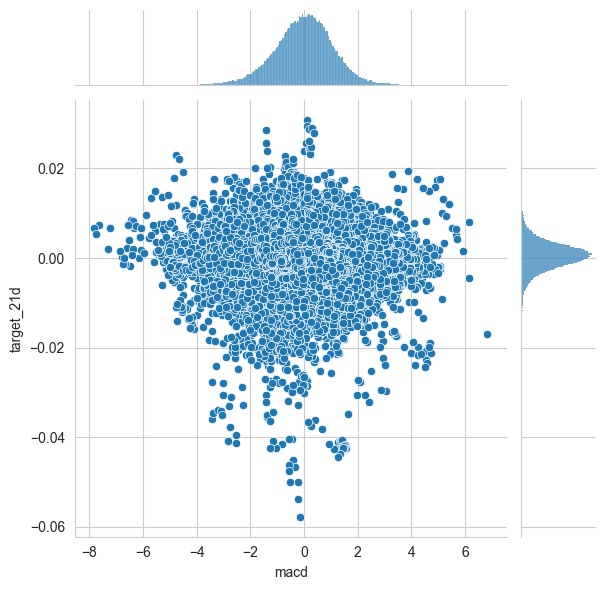

In [79]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')